In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot, scatter, plot, axis
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# Datetime
import datetime as dt
from datetime import datetime
from datetime import timedelta

import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
Industry_Portfolio=pd.read_excel("Industry_Portfolios.xlsx",index_col=0)

In [4]:
Market_Portfolio=pd.read_excel("Market_Portfolio.xlsx",index_col=0)

# Part 1: Minimum-Tracking-Error Frontier

In [5]:
for i in Industry_Portfolio.columns:
    Industry_Portfolio[str(i)] = Industry_Portfolio[i].subtract(Market_Portfolio["Market"], fill_value=0)

## Expected deviation from market return

In [6]:
Industry_Portfolio.mean(axis=0)

NoDur    0.154750
Durbl   -0.014750
Manuf    0.264750
Enrgy    0.483083
HiTec    0.018167
Telcm    0.133333
Shops    0.168250
Hlth     0.035750
Utils    0.159083
Other   -0.259000
dtype: float64

## Covariance matrix of return deviation

In [7]:
Industry_Portfolio.cov()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
NoDur,5.439696,-6.073035,-1.396192,-1.200533,-1.883151,1.538885,1.140741,3.815137,4.272002,-1.768738
Durbl,-6.073035,26.628901,4.908024,-3.481055,1.891577,-1.707625,-0.354335,-8.082946,-9.617490,4.385865
Manuf,-1.396192,4.908024,2.950499,1.666133,0.065267,-0.626416,-1.154597,-2.288900,-1.901412,0.358904
Enrgy,-1.200533,-3.481055,1.666133,19.274911,-1.516972,-1.040525,-3.710439,-2.485796,4.454368,-3.864826
HiTec,-1.883151,1.891577,0.065267,-1.516972,5.098746,-0.773294,-0.245350,-1.936284,-2.342839,-1.404050
Telcm,1.538885,-1.707625,-0.626416,-1.040525,-0.773294,4.682567,0.463797,0.693157,2.721477,-1.271778
Shops,1.140741,-0.354335,-1.154597,-3.710439,-0.245350,0.463797,4.452628,0.764510,-0.176666,-0.256987
Hlth,3.815137,-8.082946,-2.288900,-2.485796,-1.936284,0.693157,0.764510,7.820446,3.496136,-1.726842
Utils,4.272002,-9.617490,-1.901412,4.454368,-2.342839,2.721477,-0.176666,3.496136,12.267476,-4.055112
Other,-1.768738,4.385865,0.358904,-3.864826,-1.404050,-1.271778,-0.256987,-1.726842,-4.055112,4.503204


In [8]:
R=pd.DataFrame(data=Industry_Portfolio.mean(axis=0))

V=Industry_Portfolio.cov()

V_inv = pd.DataFrame(np.linalg.inv(V), columns=V.columns, index=V.index)

e = pd.DataFrame(data=np.ones((Industry_Portfolio.shape[1], 1)), 
                 index=Industry_Portfolio.columns, 
                 columns=["Dummy"])

In [9]:
# Compute Alpha
Alpha = (R.T @ V_inv @ e).values[0, 0]

# Compute Zeta
Zeta = (R.T @ V_inv @ R).values[0, 0]

# Compute Delta
Delta = (e.T @ V_inv @ e).values[0, 0]

In [10]:
# Compute 'a'
numerator_a1 = (Zeta * V_inv @ e)
numerator_a2 = (Alpha * V_inv @ R)
numerator_a = numerator_a1.values - numerator_a2.values
denominator_a = (Zeta * Delta) - Alpha**2
a = numerator_a / denominator_a

In [11]:
# Compute 'b'
numerator_b1 = (Delta * V_inv @ R)
numerator_b2 = (Alpha * V_inv @ e)
numerator_b = numerator_b1.values - numerator_b2.values
denominator_b = (Zeta * Delta) - Alpha**2
b = numerator_b / denominator_b

In [12]:
# Create the DataFrame with a range of portfolio RETURN DEVIATION as the index
returns_deviation_range = np.arange(0, 0.1, 0.001)
Minimum_tracking_error_frontier = pd.DataFrame(index=returns_deviation_range, columns=Industry_Portfolio.columns)

# Fill the DataFrame with weights based on the formula
for portfolio_return in returns_deviation_range:
    weights = a + b * portfolio_return
    Minimum_tracking_error_frontier.loc[portfolio_return, :] = weights.T

In [13]:
R_mv=Alpha/Delta

In [14]:
Minimum_tracking_error_frontier["Variance"]=(1/Delta)+(Delta/(Zeta*Delta-Alpha**2))*(Minimum_tracking_error_frontier.index-R_mv)**2
Minimum_tracking_error_frontier["SD"]=np.sqrt(Minimum_tracking_error_frontier["Variance"])

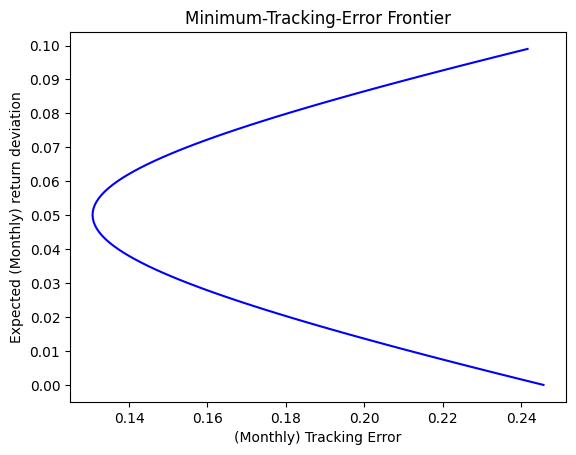

In [15]:
plt.plot(Minimum_tracking_error_frontier["SD"], 
         Minimum_tracking_error_frontier.index, 
         color='blue', 
         linestyle='-')

#in increments of 0.1%
plt.yticks(np.arange(0, 0.11, 0.01))
plt.xlabel('(Monthly) Tracking Error')
plt.ylabel('Expected (Monthly) return deviation')
plt.title('Minimum-Tracking-Error Frontier')
plt.show() 

In [16]:
rf=0

In [17]:
# Note that the np.arrange is supposed to be portfolio Tracking Error (the x-axis)
Risk_free_line = rf + np.arange(0, 2, 0.001)*(Zeta-2*Alpha*rf+Delta*(rf**2))**0.5

In [18]:
Minimum_tracking_error_frontier["Riskless_Variance"]=((Minimum_tracking_error_frontier.index-rf)**2)/(Zeta - 2*Alpha*rf + Delta*(rf**2))
Minimum_tracking_error_frontier["Riskless_SD"]=np.sqrt(Minimum_tracking_error_frontier["Riskless_Variance"])
Minimum_tracking_error_frontier["Riskless_SD"] = (Minimum_tracking_error_frontier.index-rf)/np.sqrt(Zeta - 2*Alpha*rf + Delta*(rf**2))

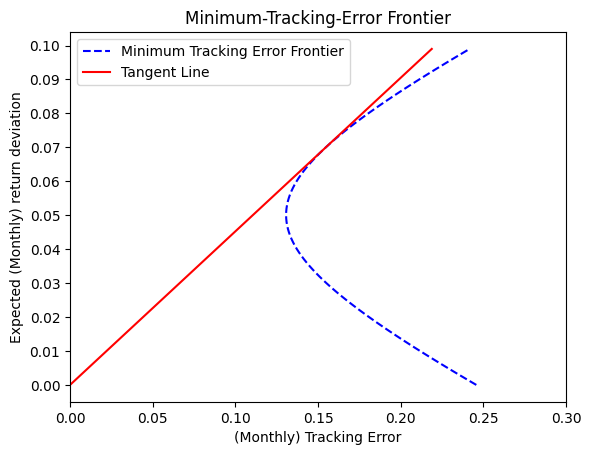

In [19]:
plt.plot(Minimum_tracking_error_frontier["SD"], 
         Minimum_tracking_error_frontier.index, 
         color='blue', 
         linestyle='--', 
         label = "Minimum Tracking Error Frontier")

plt.plot(Minimum_tracking_error_frontier["Riskless_SD"], 
         Minimum_tracking_error_frontier.index, 
         color='red', 
         linestyle='-', 
         label = "Tangent Line")

plt.yticks(np.arange(0, 0.11, 0.01))
plt.xlim(0,0.3)
plt.xlabel('(Monthly) Tracking Error')
plt.ylabel('Expected (Monthly) return deviation')
plt.title('Minimum-Tracking-Error Frontier')
plt.legend()
plt.show()

### Information ratio for the tangency portfolio

In [20]:
Information_ratio = np.sqrt(Zeta - 2*Alpha*rf + Delta*rf**2)
Information_ratio

0.4524875396199336

In [21]:
print (f'The Information ratio of the tangency portfolio is {Information_ratio:.3f}')

The Information ratio of the tangency portfolio is 0.452


In [22]:
R_tg = (Alpha*rf - Zeta)/(Delta*rf - Alpha)

In [23]:
w_star = a + b*R_tg

### Tangency portfolio weights for the ten industry portfolios.

In [24]:
Tangency_portfolio=pd.DataFrame(data=w_star,
                                index=Industry_Portfolio.columns,
                                columns=["Optimal_Weights"])
Tangency_portfolio

,Optimal_Weights
NoDur,0.052634
Durbl,0.000153
Manuf,0.137627
Enrgy,0.087032
HiTec,0.179353
Telcm,0.071074
Shops,0.106884
Hlth,0.102776
Utils,0.040162
Other,0.222304


# Part 2: Minimum-Variance Frontier w/o Short Sales

In [25]:
Industry_Portfolio=pd.read_excel("Industry_Portfolios.xlsx",index_col=0)

In [26]:
Summary = pd.DataFrame({"Mean":Industry_Portfolio.mean(),
                        "Std":Industry_Portfolio.std()})
Summary

,Mean,Std
NoDur,0.902833,3.345657
Durbl,0.733333,8.361852
Manuf,1.012833,5.310270
Enrgy,1.231167,6.081524
HiTec,0.766250,5.381191
Telcm,0.881417,4.448284
Shops,0.916333,4.093786
Hlth,0.783833,3.787172
Utils,0.907167,3.701763
Other,0.489083,5.582452


In [27]:
V=Industry_Portfolio.cov()

V_inv = pd.DataFrame(np.linalg.inv(V), columns=V.columns, index=V.index)

In [28]:
# initialize variables
n_simulations = 100000

In [29]:
# Create dataframe to store simulation results
Simulation_df = pd.DataFrame(index=range(n_simulations), columns=Summary.index)

# Add columns for Return and Std
Simulation_df["Return"] = np.nan
Simulation_df["Std"] = np.nan

# Generate random weights for all simulations and industries at once
random_weights = np.random.uniform(0, 1, (n_simulations, len(Simulation_df.columns) - 2))

# Normalize weights so that the sum of each row equals 1
random_weights = random_weights / random_weights.sum(axis=1, keepdims=True)

# Store weights in the DataFrame (for all rows at once)
Simulation_df.iloc[:, :-2] = random_weights

# Calculate the returns for all simulations at once using a dot product
Simulation_df["Return"] = np.dot(random_weights, Summary["Mean"])

# Calculate the standard deviation (portfolio volatility) for all simulations
Simulation_df["Std"] = np.sqrt(np.einsum('ij,ik,jk->i', random_weights, random_weights, V))

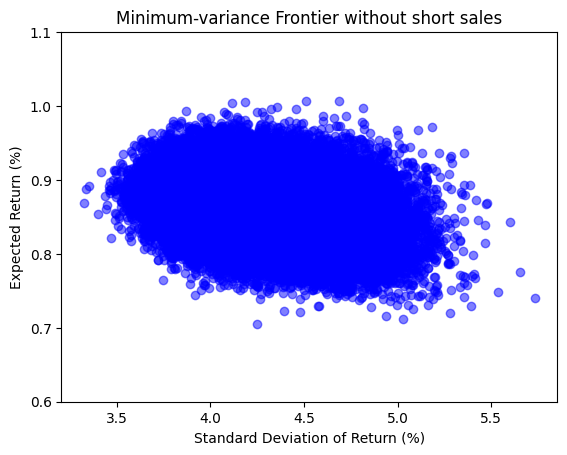

In [30]:
# Scatter plot
plt.scatter(Simulation_df["Std"], Simulation_df["Return"], color='blue',alpha=0.5)

# Set y-axis ticks in increments of 0.1%
plt.yticks(np.arange(0.6, 1.2, 0.1))

# Labeling the axes and setting title
plt.xlabel('Standard Deviation of Return (%)')
plt.ylabel('Expected Return (%)')
plt.title('Minimum-variance Frontier without short sales')

# Show the plot
plt.show()

In [31]:
# Create dataframe to store simulation results
Simulation2_df = pd.DataFrame(index=range(n_simulations), columns=Summary.index)

# Add columns for Return and Std
Simulation2_df["Return"] = np.nan
Simulation2_df["Std"] = np.nan

# Generate random weights for all simulations and industries at once
random_weights = 1 / np.random.uniform(0, 1, (n_simulations, len(Simulation2_df.columns) - 2))

# Normalize the weights so that they sum to 1 for each simulation
random_weights = random_weights / random_weights.sum(axis=1, keepdims=True)

# Store weights in the dataframe (for all rows at once)
Simulation2_df.iloc[:, :-2] = random_weights

# Calculate returns for all simulations at once
Simulation2_df["Return"] = np.dot(random_weights, Summary["Mean"])

# Calculate standard deviation (portfolio volatility) for all simulations at once
# This uses the formula sqrt(w.T @ V @ w), applied to all simulations
Simulation2_df["Std"] = np.sqrt(np.einsum('ij,ik,jk->i', random_weights, random_weights, V))

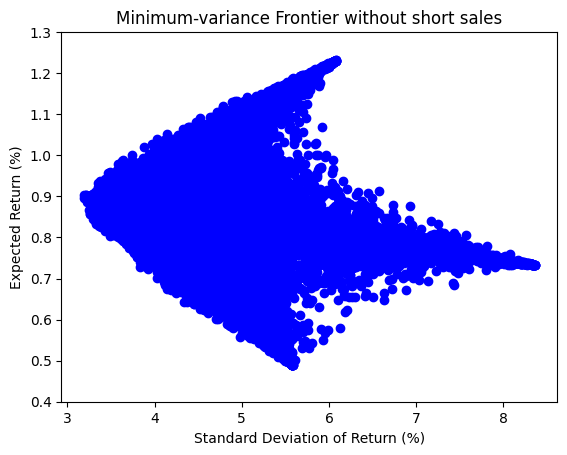

In [32]:
# Scatter plot
plt.scatter(Simulation2_df["Std"], Simulation2_df["Return"], color='blue')

# Set y-axis ticks in increments of 0.1%
plt.yticks(np.arange(0.4, 1.4, 0.1))

# Labeling the axes and setting title
plt.xlabel('Standard Deviation of Return (%)')
plt.ylabel('Expected Return (%)')
plt.title('Minimum-variance Frontier without short sales')

# Show the plot
plt.show()